In [2]:
### Essentials
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
from datetime import timedelta

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts 

#Scipy
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats.distributions import  t

#Custom function packages
import sentinnel_tools as st
import vector_tools as vt

# IMPORT, FLAG, AND CLEAN DATA

In [2]:
# Take RDI textfile and convert to xarray dataset
adcp1 = st.WinADCP_to_dataset('ADCP/ADCP01_all.txt')
adcp2 = st.WinADCP_to_dataset('ADCP/ADCP02_all.txt')

# Conduct quality assurance tests and flag data
adcp1 = st.adcp_qc(adcp1)
adcp2 = st.adcp_qc(adcp2)

#Add extra metadata to the datasets
adcp1.attrs['Description'] = 'First deployment of ADCP in Stillwater Cove'
adcp1.attrs['Latitude'] = 36.56194210195769
adcp1.attrs['Longitude'] = -121.94175918358738
adcp1.attrs['Instrument Height(m)'] = .44
adcp1.attrs['Creator'] = 'Logan Grady'
adcp1.attrs['Contact information'] = 'loganagrady@gmail.com'

adcp2.attrs['Description'] = 'Second deployment of ADCP in Stillwater Cove'
adcp2.attrs['Latitude'] = 36.56194989498659
adcp2.attrs['Longitude'] = -121.9417662787946
adcp2.attrs['Instrument Height(m)'] = .44
adcp2.attrs['Creator'] = 'Logan Grady'
adcp2.attrs['Contact information'] = 'loganagrady@gmail.com'

# Export the organized but raw data
adcp1.to_netcdf('ADCP/adcp1_raw.nc')
adcp2.to_netcdf('ADCP/adcp2_raw.nc')

Opening file and extracting data...
 
Generating xarray dataset...
 
Conversion complete!
Opening file and extracting data...
 
Generating xarray dataset...
 
Conversion complete!
Cannot conduct BIT test because variable does not exist in dataset


In [19]:
#Using flag values, cut all profiles that completely fail, and nan data points that fail
adcp1_trimmed = adcp1.where(adcp1.Flag.mean(dim = "BinDist") != 4, drop=True)
adcp1_qc = adcp1_trimmed.where(adcp1_trimmed.Flag !=4)
adcp1_qc['Flag'] = adcp1_trimmed.Flag

adcp2_trimmed = adcp2.where(adcp2.Flag.mean(dim = "BinDist") != 4, drop=True)
adcp2_qc = adcp2_trimmed.where(adcp2_trimmed.Flag !=4)
adcp2_qc['Flag'] = adcp2_trimmed.Flag

### Rotate vectors along principle axes

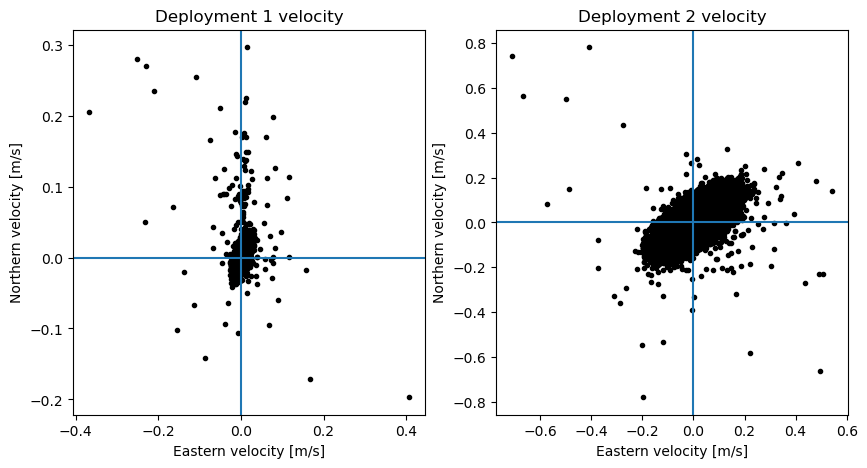

In [305]:
#Create depth averaged velocities for ENU
adcp1_qc['EastDA'] = adcp1_qc.East.mean(dim = "BinDist")
adcp1_qc['NorthDA'] = adcp1_qc.North.mean(dim = "BinDist")
adcp1_qc['VerticalDA'] = adcp1_qc.Vertical.mean(dim = "BinDist")

adcp2_qc['EastDA'] = adcp2_qc.East.mean(dim = "BinDist")
adcp2_qc['NorthDA'] = adcp2_qc.North.mean(dim = "BinDist")
adcp2_qc['VerticalDA'] = adcp2_qc.Vertical.mean(dim = "BinDist")

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(adcp1_qc.EastDA, adcp1_qc.NorthDA, '.k', label = 'Original')
plt.title('Deployment 1 velocity')
plt.xlabel('Eastern velocity [m/s]')
plt.ylabel('Northern velocity [m/s]')
plt.axhline(y=0)
plt.axvline(x=0)
          
plt.subplot(122)
plt.plot(adcp2_qc.EastDA, adcp2_qc.NorthDA, '.k', label = 'Original')
plt.title('Deployment 2 velocity')
plt.xlabel('Eastern velocity [m/s]')
plt.ylabel('Northern velocity [m/s]')
plt.axhline(y=0)
plt.axvline(x=0)

Given the shape of coastline where mooring is located:
- N/S corresponds to alongshore (primary) 
- +N = Onshore transport into SWC
- E/W corresponds to across shore (secondary)
- +E = onshore transport towards arrowhead point

In [306]:
#Create data arrays for rotated velocities along primary and secondary axes
theta1, major1, minor1 = ts.princax(adcp1_qc.EastDA, adcp1_qc.NorthDA) # theta = angle, major = SD major axis (U), SD minor axis (V)
U1, V1 = ts.rot(adcp1_qc.EastDA, adcp1_qc.NorthDA, -theta1-90)
#Add primary and secondary velocities to dataset
adcp1_qc['Primary'] = (["time"], -U1) #Signs are flipped for primary and secondary to indicate onshore velocities
adcp1_qc['Secondary'] = (["time"], -V1)#as positive, not negative
adcp1_qc.attrs['Rotation angle'] = -theta1-90

theta2, major2, minor2 = ts.princax(adcp2_qc.EastDA, adcp2_qc.NorthDA) # theta = angle, major = SD major axis (U), SD minor axis (V)
U2, V2 = ts.rot(adcp2_qc.EastDA, adcp2_qc.NorthDA, -theta2-90)
#Add primary and secondary velocities to dataset
adcp2_qc['Primary'] = (["time"], -U2) 
adcp2_qc['Secondary'] = (["time"], -V2)
adcp2_qc.attrs['Rotation angle'] = -theta2-90

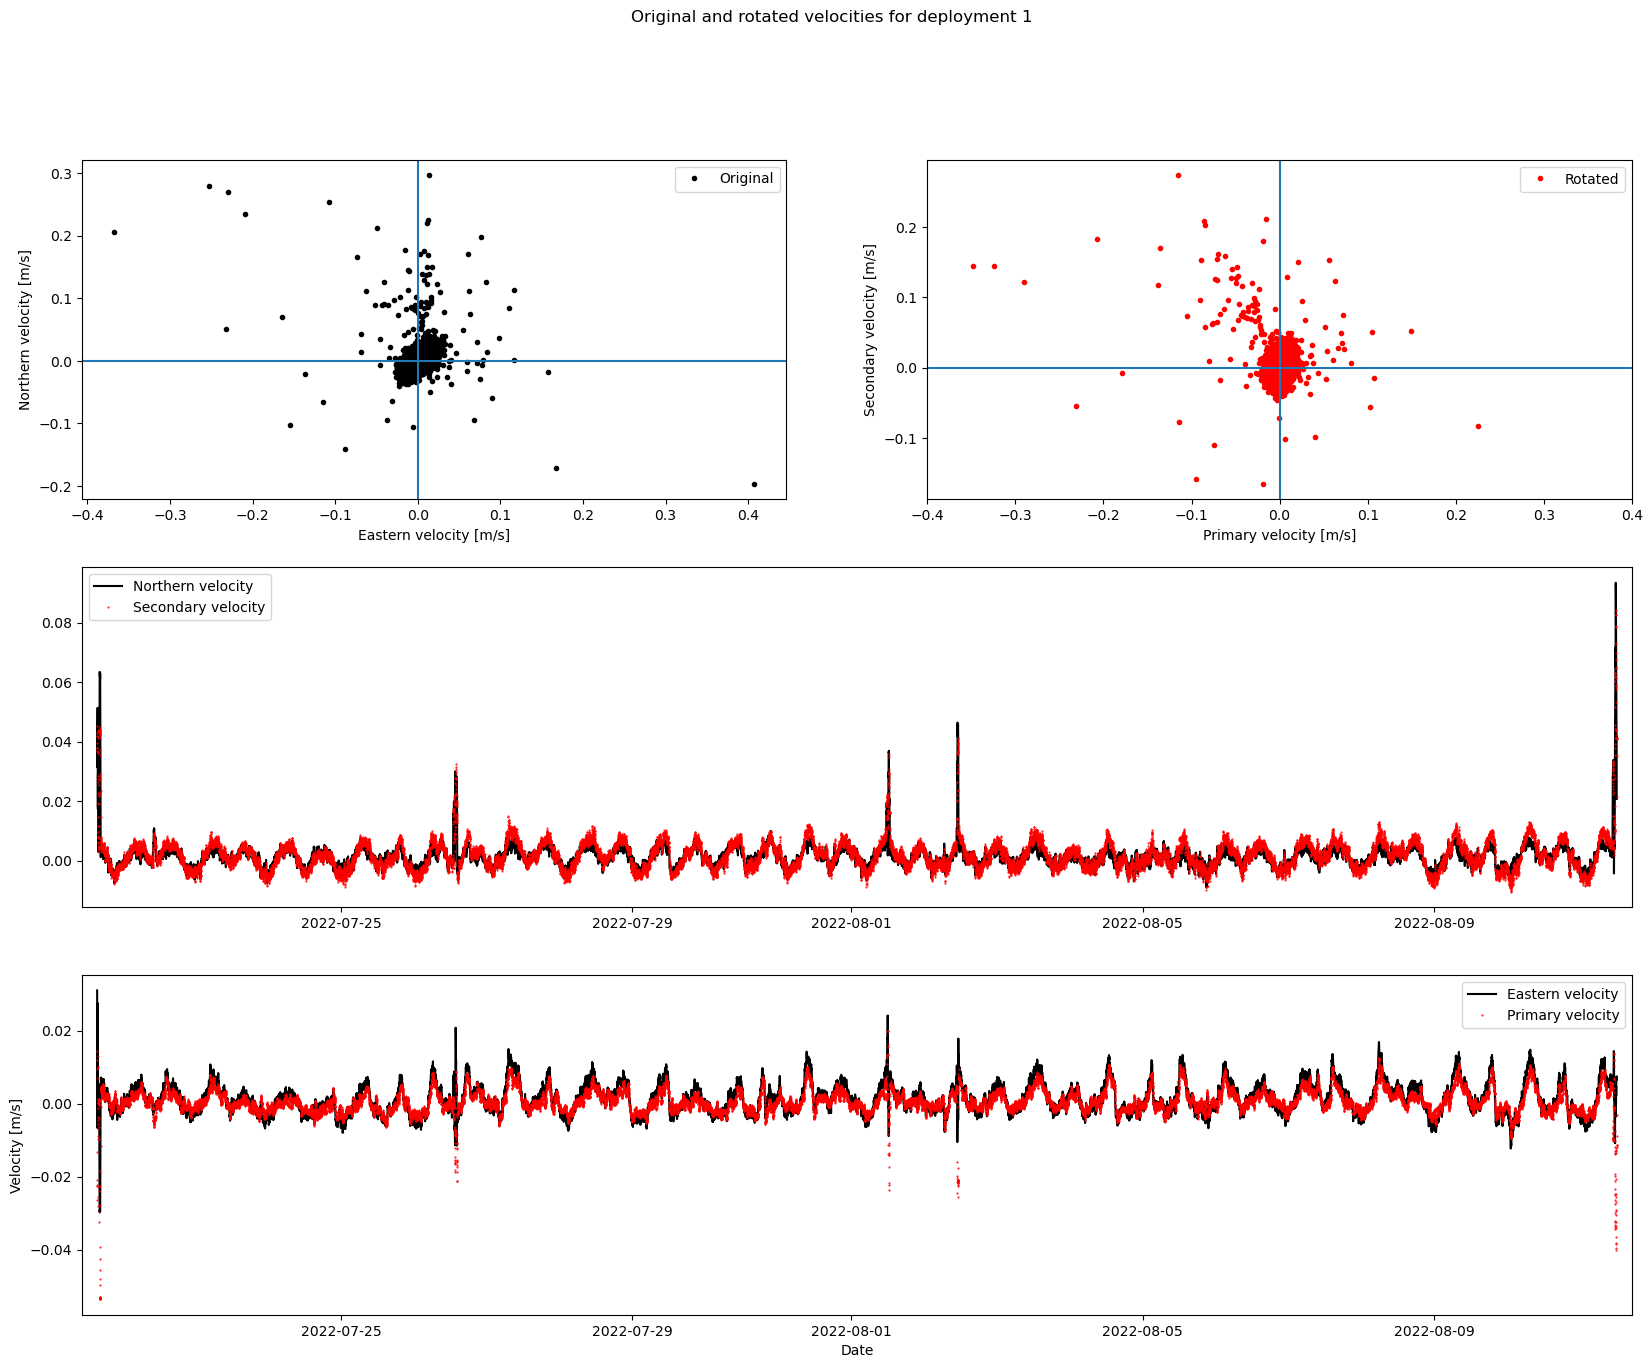

In [318]:
adcp1_Prim_20mRoll = adcp1_qc.Primary.rolling(time=20).mean()
adcp1_Sec_20mRoll = adcp1_qc.Secondary.rolling(time=20).mean()
adcp1_North_20mRoll = adcp1_qc.NorthDA.rolling(time=20).mean()
adcp1_East_20mRoll = adcp1_qc.EastDA.rolling(time=20).mean()

plt.figure(figsize=(20,15))
plt.suptitle('Original and rotated velocities for deployment 1')

plt.subplot(321)
plt.plot(adcp1_qc.EastDA, adcp1_qc.NorthDA, '.k', label = 'Original')
plt.xlabel('Eastern velocity [m/s]')
plt.ylabel('Northern velocity [m/s]')
plt.axhline(y=0)
plt.axvline(x=0)
plt.legend()

plt.subplot(322)
plt.plot(adcp1_qc.Primary, adcp1_qc.Secondary, '.r', label = 'Rotated')
plt.xlabel('Primary velocity [m/s]')
plt.ylabel('Secondary velocity [m/s]')
plt.xlim(-.4, .4)
plt.axhline(y=0)
plt.axvline(x=0)
plt.legend()

plt.subplot(312)
plt.plot(adcp1_North_20mRoll.time, adcp1_North_20mRoll, '-k', label = 'Northern velocity')
plt.plot(adcp1_Sec_20mRoll.time, adcp1_Sec_20mRoll, '.r', ms = 1, label = 'Secondary velocity')
plt.margins(x=.01)
plt.legend()

plt.subplot(313)
plt.plot(adcp1_East_20mRoll.time, adcp1_East_20mRoll, '-k', label = 'Eastern velocity')
plt.plot(adcp1_Prim_20mRoll.time, adcp1_Prim_20mRoll, '.r', ms = 1, label = 'Primary velocity')
plt.ylabel('Velocity [m/s]')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Date')
plt.margins(x=.01)
plt.legend()

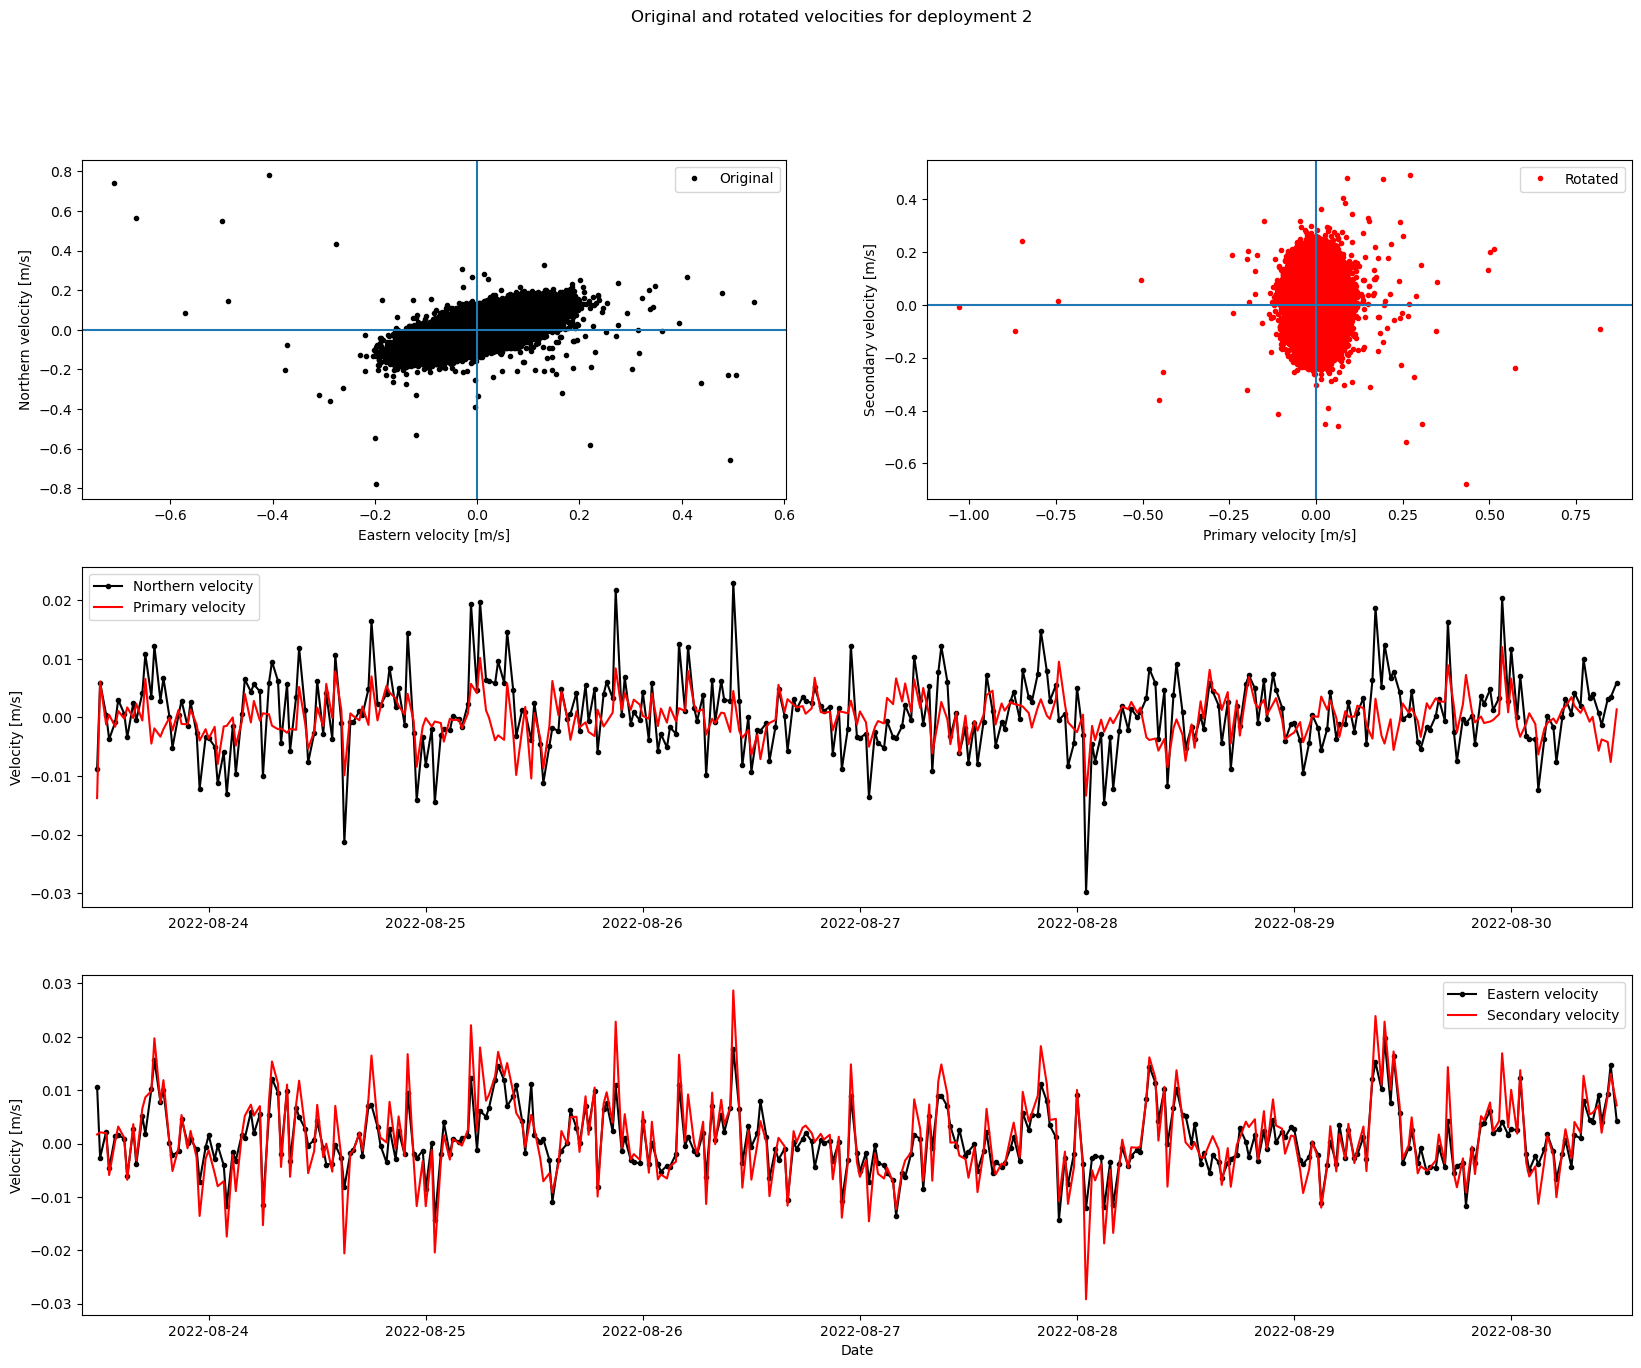

In [320]:
adcp2_Prim_20m = adcp2_qc.Primary.resample(time='20Min').mean().dropna(dim = 'time')
adcp2_Sec_20m = adcp2_qc.Secondary.resample(time='20Min').mean().dropna(dim = 'time')
adcp2_North_20m = adcp2_qc.NorthDA.resample(time='20Min').mean().dropna(dim = 'time')
adcp2_East_20m = adcp2_qc.EastDA.resample(time='20Min').mean().dropna(dim = 'time')

plt.figure(figsize=(20,15))
plt.suptitle('Original and rotated velocities for deployment 2')

plt.subplot(321)
plt.plot(adcp2_qc.EastDA, adcp2_qc.NorthDA, '.k', label = 'Original')
plt.xlabel('Eastern velocity [m/s]')
plt.ylabel('Northern velocity [m/s]')
plt.axhline(y=0)
plt.axvline(x=0)
plt.legend()

plt.subplot(322)
plt.plot(adcp2_qc.Primary, adcp2_qc.Secondary, '.r', label = 'Rotated')
plt.xlabel('Primary velocity [m/s]')
plt.ylabel('Secondary velocity [m/s]')
plt.axhline(y=0)
plt.axvline(x=0)
plt.legend()

plt.subplot(312)
plt.plot(adcp2_North_20m.time, adcp2_North_20m, '.-k', label = 'Northern velocity')
plt.plot(adcp2_Prim_20m.time, -adcp2_Prim_20m, '-r', label = 'Primary velocity')

plt.ylabel('Velocity [m/s]')
plt.margins(x=.01)
plt.legend()

plt.subplot(313)
plt.plot(adcp2_East_20m.time, adcp2_East_20m, '.-k', label = 'Eastern velocity')
plt.plot(adcp2_Sec_20m.time, adcp2_Sec_20m, '-r', label = 'Secondary velocity')

plt.ylabel('Velocity [m/s]')
plt.xlabel('Date')
plt.margins(x=.01)
plt.legend()

In [321]:
adcp1_qc.Primary.attrs['Description'] = 'Depth averaged velocity along primary axis, coincides with across shore velocity'
adcp1_qc.Secondary.attrs['Description'] = 'Depth averaged velocity along secondary axis, coincides with alongshore velocity'

adcp2_qc.Primary.attrs['Description'] = 'Depth averaged velocity along primary axis, coincides with alongshore velocity'
adcp2_qc.Secondary.attrs['Description'] = 'Depth averaged velocity along secondary axis, coincides with across shore velocity'

In [323]:
#Export clean data to netcdf
adcp1_qc.to_netcdf('ADCP/adcp1_final2.nc')
adcp2_qc.to_netcdf('ADCP/adcp2_final2.nc')

# RESAMPLE DATA
Types of resamples:
- Depth averaged
- 20-minute average
- 20-minute rolling average (only applicable for continuous data)

In [24]:
#Import clean data to xarray datasets
adcp1_qc = xr.open_dataset('ADCP/adcp1_final.nc')
adcp2_qc = xr.open_dataset('ADCP/adcp2_final.nc')

In [303]:
#Import clean data to xarray datasets
adcp1_qc = xr.open_dataset('ADCP/adcp1_qc.nc')
adcp2_qc = xr.open_dataset('ADCP/adcp2_qc.nc')

In [17]:
#First deployment
adcp1_DA = adcp1.mean(dim = "BinDist")
adcp1_20m = adcp1_DA.resample(time='20Min').mean()
adcp1_20mRoll = adcp1_DA.rolling(time=20).mean()

#Second deployment
adcp2_DA = adcp2.mean(dim = "BinDist")
adcp2_20m = adcp2_DA.resample(time='20Min').mean()

In [27]:
#Export resampled datasets
adcp1_DA.to_netcdf('ADCP/adcp1_DA.nc')
adcp1_20m.to_netcdf('ADCP/adcp1_20m.nc')
adcp1_20mRoll.to_netcdf('ADCP/adcp1_20mRoll.nc')
adcp2_DA.to_netcdf('ADCP/adcp2_DA.nc')
adcp2_20m.to_netcdf('ADCP/adcp2_20m.nc')

# Plotting
Check how the various datasets look

(array([19196., 19198., 19200., 19202., 19204., 19205., 19207., 19209.,
        19211., 19213., 19215.]),
 [Text(19196.0, 0, '2022-07-23'),
  Text(19198.0, 0, '2022-07-25'),
  Text(19200.0, 0, '2022-07-27'),
  Text(19202.0, 0, '2022-07-29'),
  Text(19204.0, 0, '2022-07-31'),
  Text(19205.0, 0, '2022-08-01'),
  Text(19207.0, 0, '2022-08-03'),
  Text(19209.0, 0, '2022-08-05'),
  Text(19211.0, 0, '2022-08-07'),
  Text(19213.0, 0, '2022-08-09'),
  Text(19215.0, 0, '2022-08-11')])

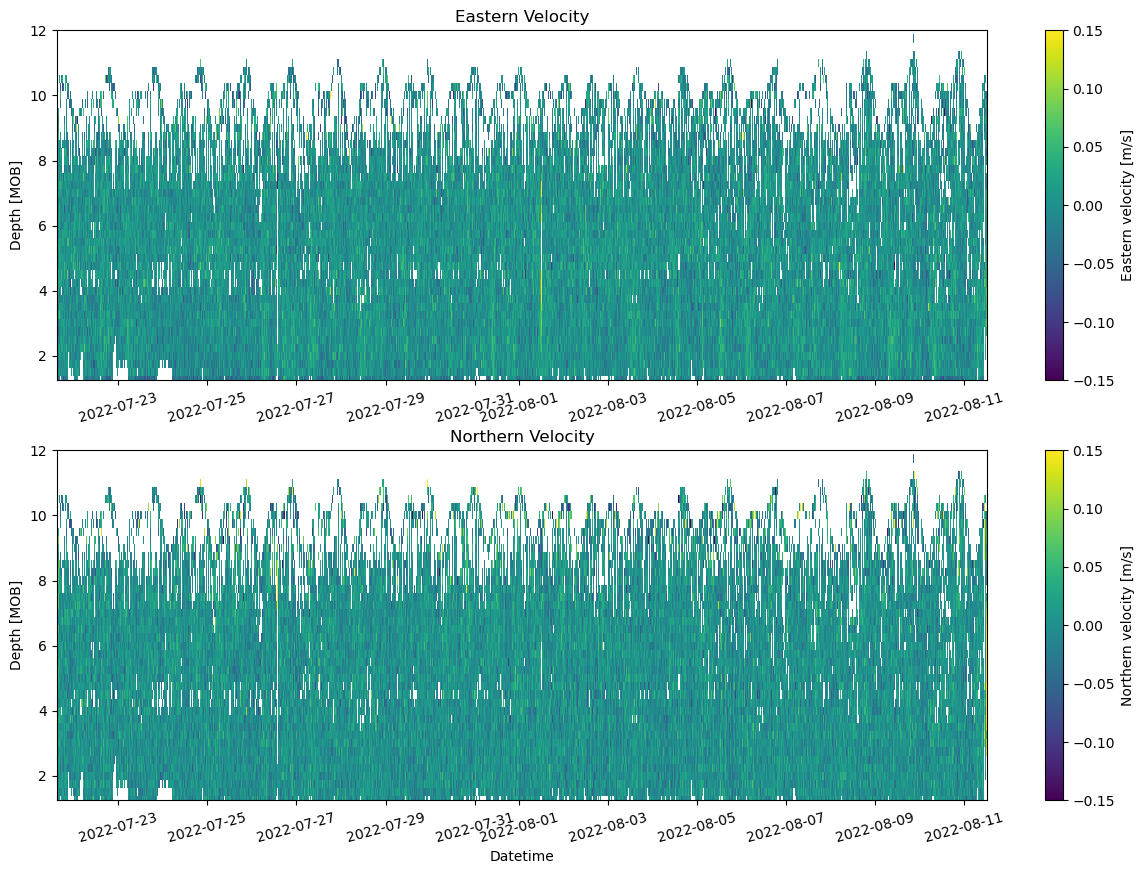

In [13]:
#Full profile colorplots
ds = adcp1
minvel = -.15 # Limits for the colorbars used on the adcp colorplots
maxvel = .15
norm = matplotlib.colors.Normalize(vmin=minvel,vmax=maxvel)

plt.figure(figsize = (15,10))

plt.subplot(211)
plt.title('Eastern Velocity')
plt.pcolormesh(ds.time, (ds.BinDist)+.44, ds.East,norm=norm)
plt.colorbar(label='Eastern velocity [m/s]')
plt.ylim(1.25,12)
plt.ylabel('Depth [MOB]')
plt.xticks(rotation= 15)

plt.subplot(212)
plt.title('Northern Velocity')
plt.pcolormesh(ds.time, (ds.BinDist)+.44, ds.North,norm=norm)
plt.colorbar(label='Northern velocity [m/s]')
plt.ylim(1.25,12)
plt.ylabel('Depth [MOB]')
plt.xlabel('Datetime')
plt.xticks(rotation= 15)

(-0.05, 0.05)

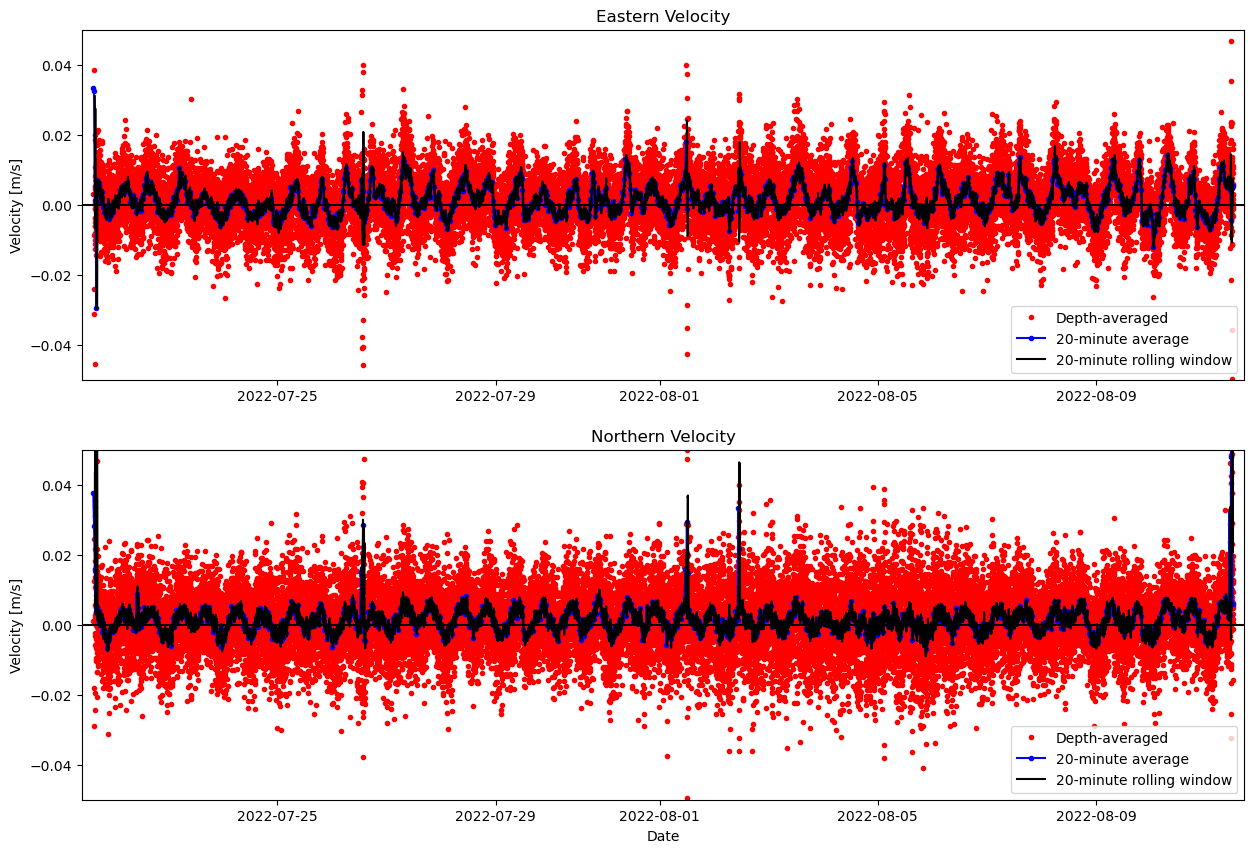

In [26]:
# Across shore colorplot
ds_DA = adcp1_DA
ds_avg = adcp1_20m
ds_roll = adcp1_20mRoll

plt.figure(figsize = (15,10))

plt.subplot(211)
plt.plot(ds_DA.time, ds_DA.East, '.r', label = "Depth-averaged")
plt.plot(ds_avg.time, ds_avg.East, '.-b', label = "20-minute average")
if ds_roll:
    plt.plot(ds_roll.time, ds_roll.East, '-k', label = "20-minute rolling window")
plt.axhline(y = 0, c = 'black')
plt.title('Eastern Velocity')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.margins(x=.01)
plt.ylim(-.05, .05)

plt.subplot(212)
plt.plot(ds_DA.time, ds_DA.North, '.r', label = "Depth-averaged")
plt.plot(ds_avg.time, ds_avg.North, '.-b', label = "20-minute average")
if ds_roll:
    plt.plot(ds_roll.time, ds_roll.North, '-k', label = "20-minute rolling window")
plt.axhline(y = 0, c = 'black')
plt.title('Northern Velocity')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Date')
plt.legend()
plt.margins(x=.01)
plt.ylim(-.05, .05)

(-0.05, 0.05)

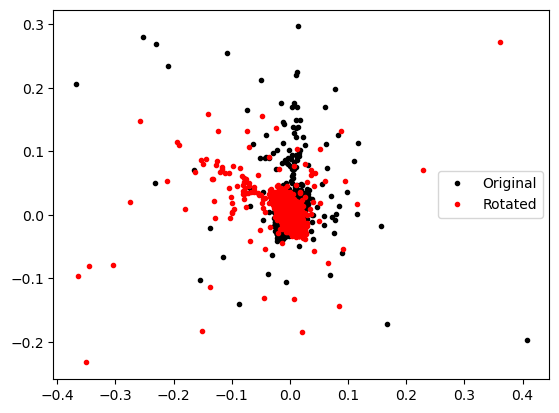

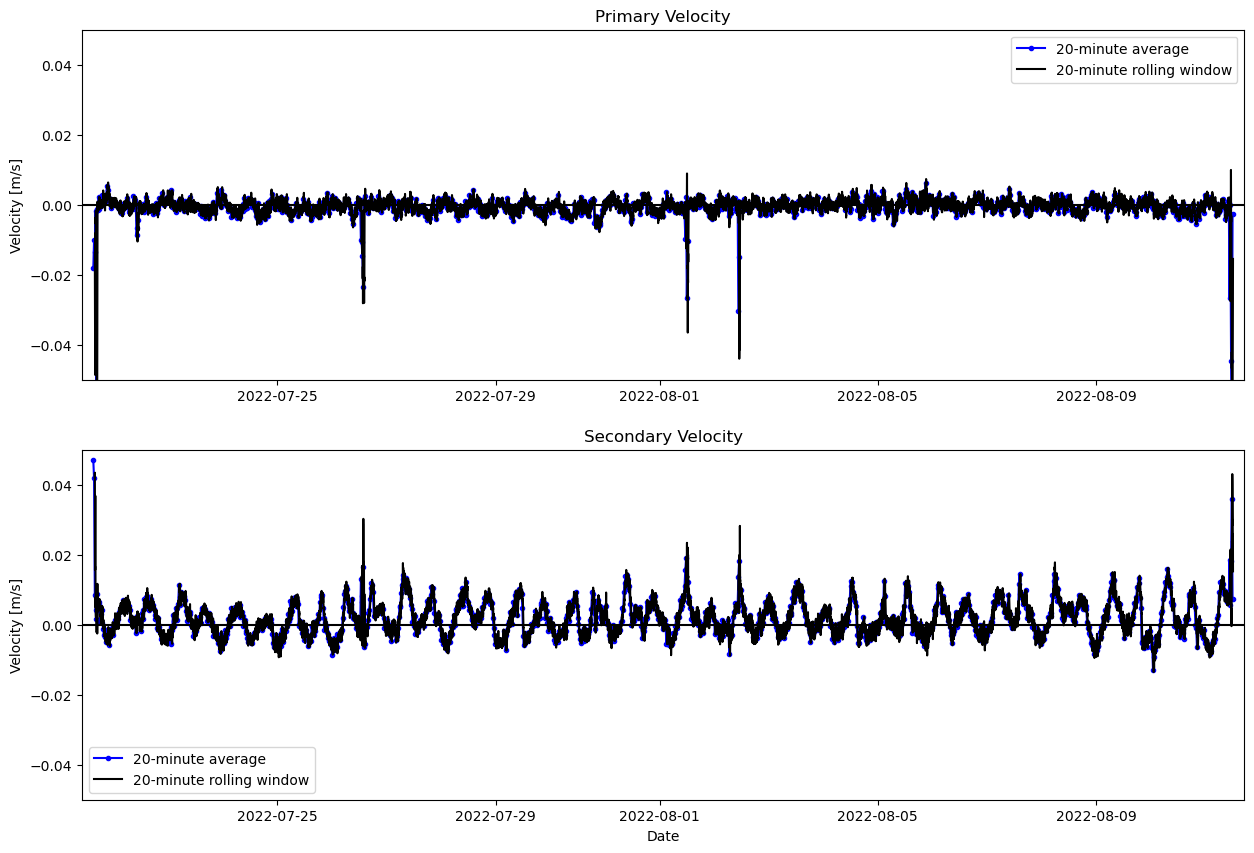

In [20]:
# Across shore colorplot
ds_DA = adcp1_DA
ds_avg = adcp1_20m
ds_roll = adcp1_20mRoll

plt.figure(figsize = (15,10))

plt.subplot(211)
#plt.plot(ds_avg.time, ds_avg.Primary, '.-b', label = "20-minute average")
if ds_roll:
    plt.plot(ds_roll.time, ds_roll.Primary, '-k', label = "20-minute rolling window")
plt.axhline(y = 0, c = 'black')
plt.title('Primary Velocity')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.margins(x=.01)
plt.ylim(-.05, .05)

plt.subplot(212)
#plt.plot(ds_DA.time, ds_DA.North, '.r', label = "Depth-averaged")
plt.plot(ds_avg.time, ds_avg.Secondary, '.-b', label = "20-minute average")
if ds_roll:
    plt.plot(ds_roll.time, ds_roll.Secondary, '-k', label = "20-minute rolling window")
plt.axhline(y = 0, c = 'black')
plt.title('Secondary Velocity')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Date')
plt.legend()
plt.margins(x=.01)
plt.ylim(-.05, .05)

# BEAM COORDINATES

In [ ]:
# Import the beam coordinate csv's
b1 = pd.read_csv('ADCP/SWC2_000_1_export.csv')
b2 = pd.read_csv('ADCP/SWC2_000_2_export.csv')
b3 = pd.read_csv('ADCP/SWC2_000_3_export.csv')
b4 = pd.read_csv('ADCP/SWC2_000_4_export.csv')

In [ ]:
# Combine the csv's in chronological order
#data = b1.append(b2)
#data = data.append(b3)
#data = data.append(b4)
#data = data.reset_index(drop=True)
#data = data.drop(columns=['index'])
#data.to_csv('ADCP/beam_data.csv', index=False)
data = pd.read_csv('ADCP/beam_data.csv')

In [ ]:
vel = data.filter(like='V')

In [ ]:
vel_B1 = vel.filter(like='B1')
vel_B2 = vel.filter(like='B2')
vel_B3 = vel.filter(like='B3')
vel_B4 = vel.filter(like='B4')

In [ ]:
time = pd.to_datetime(data.iloc[:,1])
dcell = range(1,48,1)

In [ ]:
B1_arr = vel_B1.to_numpy()
B2_arr = vel_B2.to_numpy()
B3_arr = vel_B3.to_numpy()
B4_arr = vel_B4.to_numpy()

In [ ]:
# create coords
rows = range(1,48,1) 
cols = time

# put data into a dataset
ds = xr.Dataset(
    data_vars=dict(
        B1=(["time", "dcell"], B1_arr),
        B2=(["time", "dcell"], B2_arr),
        B3=(["time", "dcell"], B3_arr),
        B4=(["time", "dcell"], B4_arr)
    ),
    coords=dict(
        dcell=(["dcell"], rows),
        time=(["time"], cols),
    ),
    attrs=dict(description="Velocity in beam coordinates"),
)

In [ ]:
ds['B1'].attrs['units'] = 'mm/s'
ds['B2'].attrs['units'] = 'mm/s'
ds['B3'].attrs['units'] = 'mm/s'
ds['B4'].attrs['units'] = 'mm/s'